In [98]:
!pip install dask[dataframe]
!pip install optuna
!pip install --upgrade lightgbm


In [99]:
#importacion de librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

***Revisar y visualizar datos***

In [101]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [103]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [104]:
#Identificar el origen y que significa cada variable
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Descripción de las Variables del Conjunto de Datos para Predecir Ictus

1. **gender**:
   - Género de la persona. Los valores posibles suelen ser:
     - `Male`: Hombre
     - `Female`: Mujer
2. **age**:
   - Edad de la persona en años.
3. **hypertension**:
   - Indica si la persona tiene o no hipertensión (presión arterial alta).
   - Valores:
     - `0`: No tiene hipertensión
     - `1`: Tiene hipertensión
4. **heart_disease**:
   - Indica si la persona tiene alguna enfermedad cardíaca.
   - Valores:
     - `0`: No tiene enfermedad cardíaca
     - `1`: Tiene enfermedad cardíaca

5. **ever_married**:
   - Indica si la persona alguna vez se ha casado.
   - Valores posibles:
     - `Yes`: Sí
     - `No`: No
6. **work_type**:
   - Tipo de trabajo que realiza la persona.
   - Valores posibles:
     - `Private`: Sector privado
     - `Self-employed`: Trabajador autónomo
     - `Govt_job`: Empleado del gobierno
     - `children`: Niños
7. **Residence_type**:
   - Tipo de residencia de la persona.
   - Valores posibles:
     - `Urban`: Zona urbana
     - `Rural`: Zona rural
8. **avg_glucose_level**:
   - Nivel promedio de glucosa en la sangre de la persona (medido en mg/dL).

9. **bmi**:
   - Índice de Masa Corporal (BMI, por sus siglas en inglés) de la persona, que se calcula como el peso en kilogramos dividido por el cuadrado de la altura en metros.

10. **smoking_status**:
    - Indica el estado de consumo de tabaco de la persona.
    - Valores posibles:
      - `formerly smoked`: Fumó anteriormente
      - `never smoked`: Nunca ha fumado
      - `smokes`: Actualmente fuma
      - `Unknown`: No se tiene información sobre el consumo de tabaco

11. **stroke**:
    - Variable objetivo que indica si la persona ha tenido un ictus.
    - Valores:
      - `0`: No ha tenido un ictus
      - `1`: Ha tenido un ictus
    

In [105]:
#revisar los tipos de datos para transformar
df.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64
smoking_status,object


In [106]:
#convertir float a int
df['age'] = df['age'].astype(int)
df['age']

,age
0,67
1,80
2,49
3,79
4,81
...,...
4976,41
4977,40
4978,45
4979,40


***Tratamiento de variables***

In [107]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children'], dtype=object)

In [108]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


**Gràficos y anàlisis***

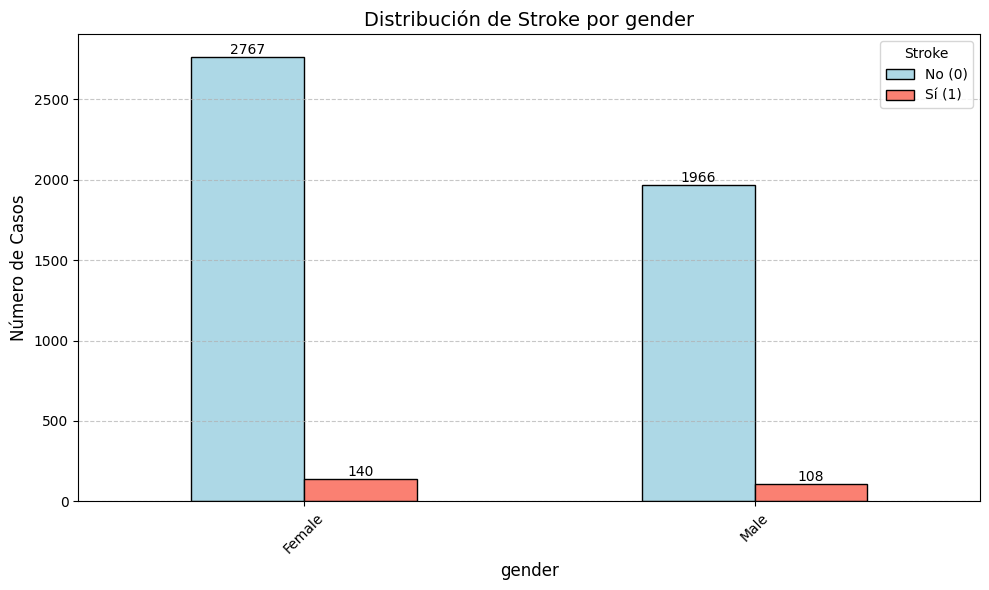

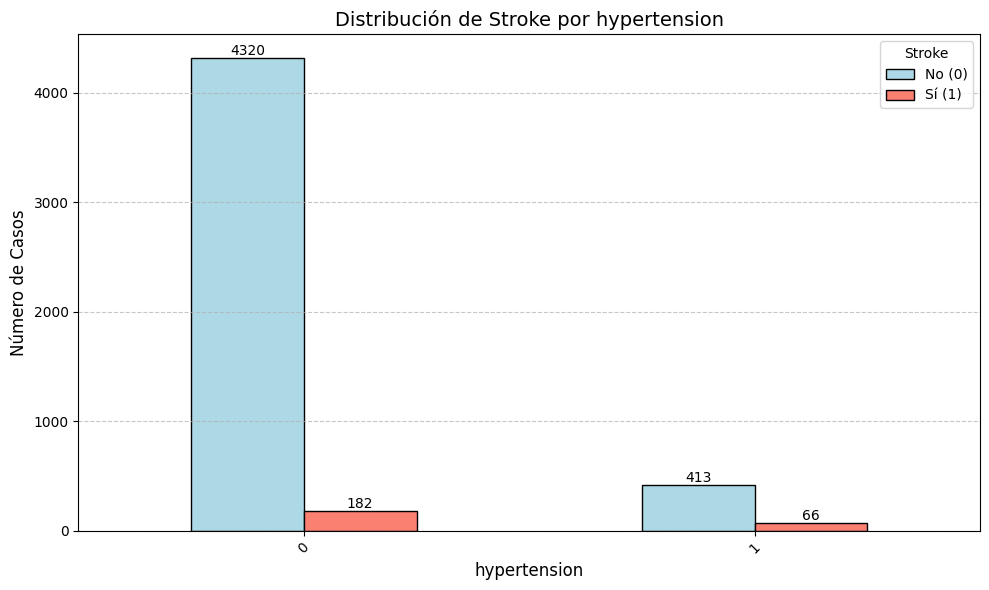

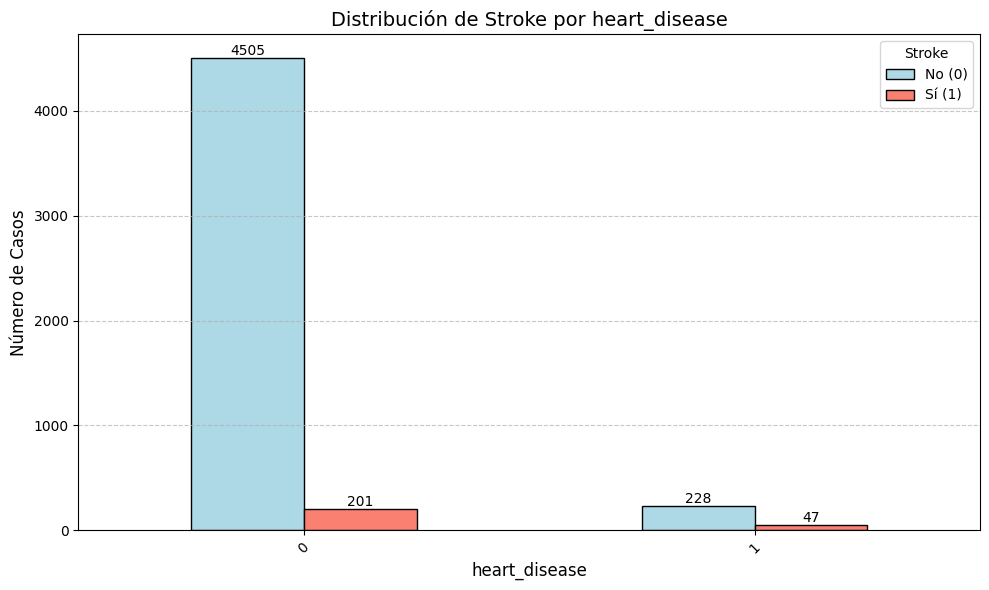

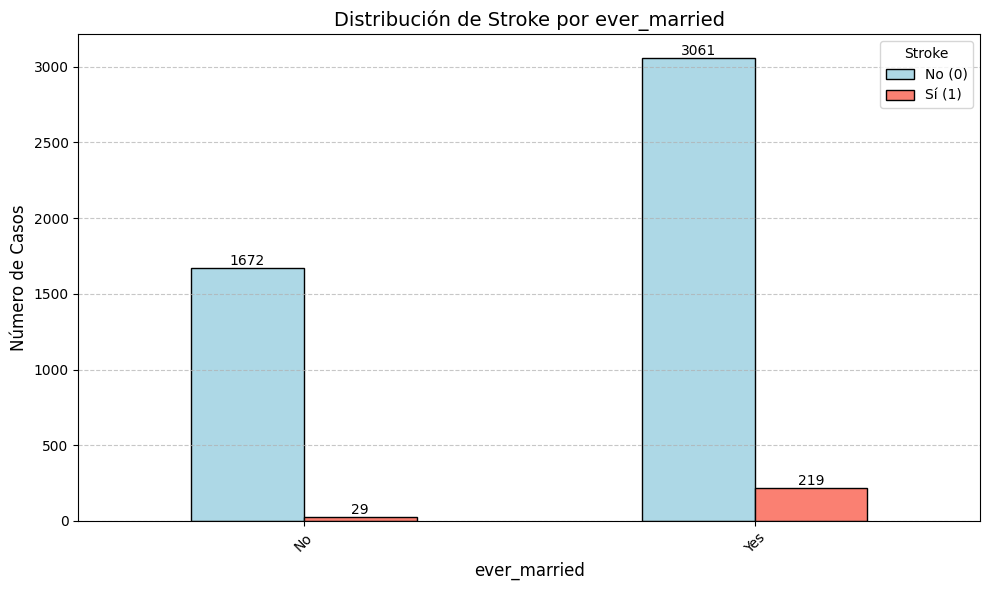

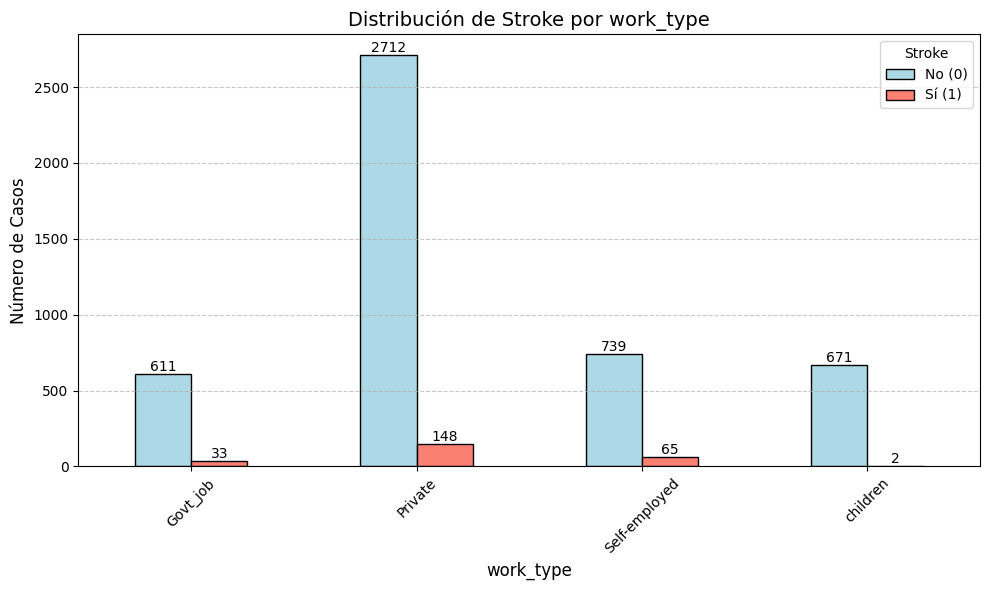

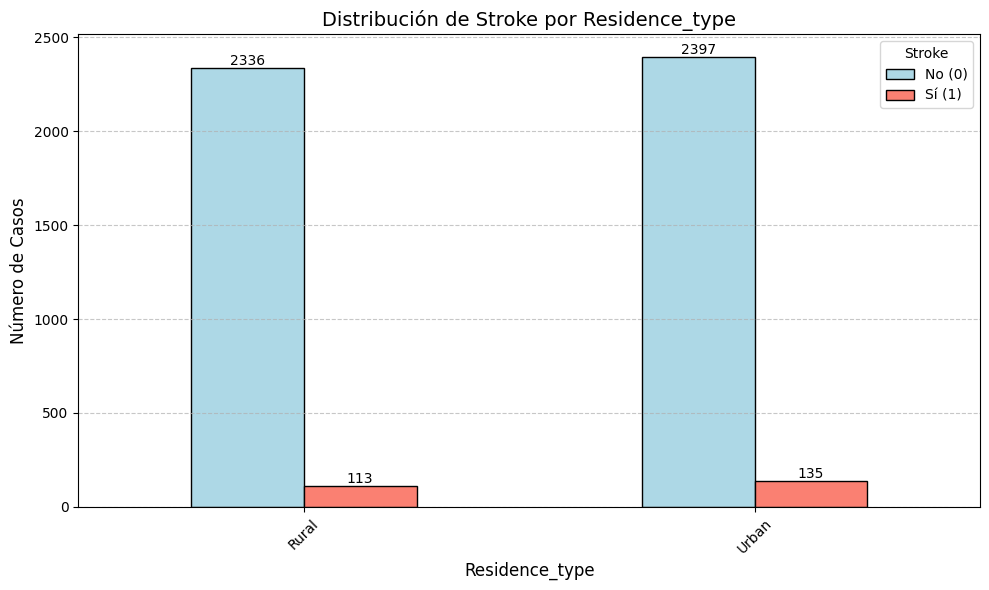

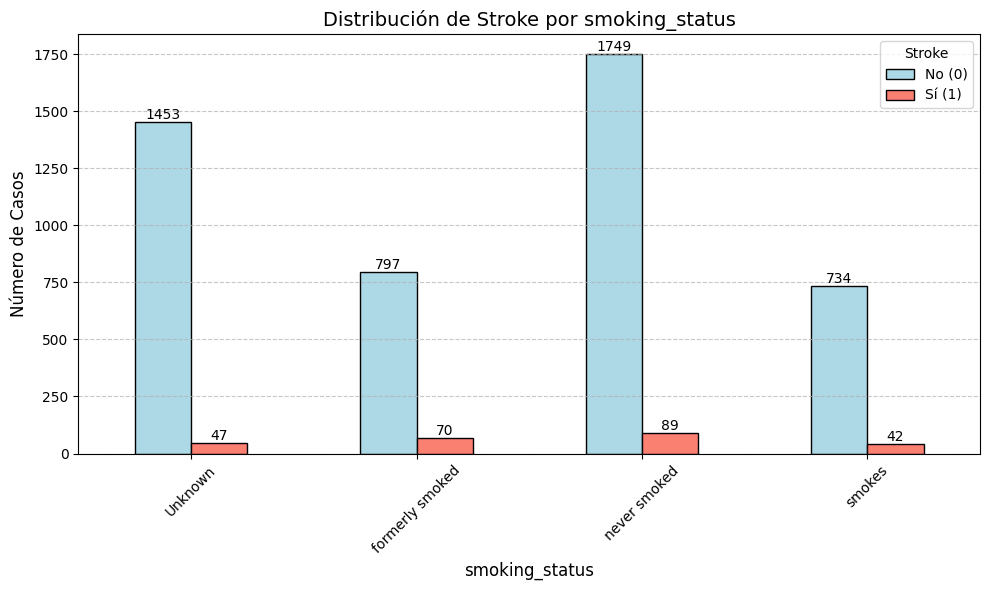

In [109]:
# Lista de columnas a graficar contra 'stroke'
columns_to_plot = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                   'work_type', 'Residence_type', 'smoking_status']

# Generar gráficos de barras agrupadas para cada columna
for column in columns_to_plot:
    stroke_counts = df.groupby([column, 'stroke']).size().unstack(fill_value=0)

    # Crear el gráfico de barras agrupadas
    ax = stroke_counts.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'salmon'], edgecolor='black')

    # Personalizar el gráfico
    plt.title(f'Distribución de Stroke por {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Número de Casos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Stroke', labels=['No (0)', 'Sí (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Agregar los números sobre cada barra
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

***Grafico gender vs stroke***

 El accidente cerebrovascular es menos frecuente que la ausencia del mismo en ambas categorías de género.

***Grafico HTA vs stroke***

 Este gráfico sugiere que la hipertensión podría ser un factor de riesgo importante para sufrir un accidente cerebrovascular. A pesar de que hay más personas sin hipertensión en el dataset, la proporción de casos de accidente cerebrovascular es mayor entre quienes sí tienen hipertensión.

 ***Grafico hearth_disease vs stroke***

 Indica que la cantidad de personas que sufrieron un ictus relacionado a enfermedades del corazon es menor que los que no las padecian.

  ***Grafico ever_married vs stroke***

  Indica que la cantidad de personas que sufrieron un ictus relacionado con el matrimonio fueron mas que las que lo sufrieron estando solteras.

  ***Grafico Work type vs stroke***

  Indica que la relacion entre el trabajo y la posibilidad de haber sufrido ictus es mayor para los que trabajaban en el area privada respecto a los niños que no tienen que trabajar. Y en segundo lugar del puesto de trabajo con mayor posibilidad de sufrir ictus es para quienes  trabajan por cuenta propia.

  ***Grafico Smoking status vs stroke***

  Muestra que en las ciudades hay mayores casos de personas con ictus respectoa los pueblos o zonas rurales.

 ***Grafico Residence type vs stroke***


 Muestra que hay una cantidad casi pareja de casos de personas con ictus en relacion a si eran fumadores o no

In [110]:
# Filtrar las personas menores de 18 años con 'Unknown' en 'smoking_status'
menores_18_unknown = df[(df['age'] < 18) & (df['smoking_status'] == 'Unknown')]

# Mostrar el conteo de personas menores de 18 años con 'Unknown' en 'smoking_status' y con 'never_smoked' antes de la imputación
conteo_menores_18_unknown = menores_18_unknown.shape[0]
conteo_never_smoked_antes = df[(df['age'] < 18) & (df['smoking_status'] == 'never smoked')].shape[0]
print(f"Conteo de personas menores de 18 años con 'Unknown' en 'smoking_status' antes de la imputación: {conteo_menores_18_unknown}")
print(f"Conteo de personas menores de 18 años con 'never smoked' en 'smoking_status' antes de la imputación: {conteo_never_smoked_antes}")

# Imputar el valor 'never smoked' a estas personas
df.loc[(df['age'] < 18) & (df['smoking_status'] == 'Unknown'), 'smoking_status'] = 'never smoked'

# Verificar el conteo después de la imputación
conteo_menores_18_unknown_despues = df[(df['age'] < 18) & (df['smoking_status'] == 'Unknown')].shape[0]
conteo_never_smoked_despues = df[(df['age'] < 18) & (df['smoking_status'] == 'never smoked')].shape[0]
print(f"Conteo de personas menores de 18 años con 'Unknown' en 'smoking_status' después de la imputación: {conteo_menores_18_unknown_despues}")
print(f"Conteo de personas menores de 18 años con 'never smoked' en 'smoking_status' después de la imputación: {conteo_never_smoked_despues}")

Conteo de personas menores de 18 años con 'Unknown' en 'smoking_status' antes de la imputación: 661
Conteo de personas menores de 18 años con 'never smoked' en 'smoking_status' antes de la imputación: 128
Conteo de personas menores de 18 años con 'Unknown' en 'smoking_status' después de la imputación: 0
Conteo de personas menores de 18 años con 'never smoked' en 'smoking_status' después de la imputación: 789


In [111]:
# Volvemos a calcular los valores de 'Unknown' después de la imputación
desconocidos = df['smoking_status'].value_counts().get('Unknown', 0)

# Mostrar el número de veces que aparece 'Unknown' en 'smoking_status'
print(f"Número de 'Unknown' en 'smoking_status': {desconocidos}")

Número de 'Unknown' en 'smoking_status': 839


In [112]:
# Filtrar las personas menores de 16 años con 'children' en la columna 'work_type'
menores_con_children = df[(df['age'] < 16) & (df['work_type'] == 'children')]

# Contar las personas menores de 16 con 'children' antes de la imputación
conteo_antes_imputacion = menores_con_children.shape[0]
print(f"Conteo de personas menores de 16 años con 'children' antes de la imputación: {conteo_antes_imputacion}")

# Imputar el valor 'Never_worked' para los menores de 16 con 'children'
df.loc[(df['age'] < 16) & (df['work_type'] == 'children'), 'work_type'] = 'Never_worked'

# Verificar si el cambio se ha realizado correctamente, mostrando el conteo después de la imputación
personas_con_children_post_imputacion = df[df['work_type'] == 'children']
conteo_post_imputacion = personas_con_children_post_imputacion.shape[0]
print(f"Conteo de personas con 'children' después de la imputación: {conteo_post_imputacion}")

# Mostrar las personas que aún tienen 'children' en 'work_type'
print("Personas que aún tienen 'children' en 'work_type':")
personas_con_children_post_imputacion

Conteo de personas menores de 16 años con 'children' antes de la imputación: 662
Conteo de personas con 'children' después de la imputación: 11
Personas que aún tienen 'children' en 'work_type':


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
247,Female,16,0,0,No,children,Rural,110.63,19.5,never smoked,0
409,Female,16,0,0,No,children,Rural,113.47,19.5,never smoked,0
840,Female,16,0,0,No,children,Rural,109.02,19.8,never smoked,0
1345,Male,16,0,0,No,children,Urban,102.30,21.9,never smoked,0
2344,Male,16,0,0,No,children,Rural,134.23,30.6,never smoked,0
3115,Male,16,0,0,No,children,Rural,106.11,22.4,never smoked,0
3457,Female,16,0,0,No,children,Urban,64.51,21.2,never smoked,0
3739,Male,16,0,0,No,children,Rural,91.58,15.8,never smoked,0
4241,Male,16,0,0,No,children,Urban,135.82,35.1,never smoked,0
4299,Male,16,0,0,No,children,Urban,140.10,38.7,never smoked,0


In [113]:
df.loc[df['work_type'] == 'children', 'work_type'] = 'Never_worked'

# Verificar si 'children' aún existe en el dataset
print("\nValores únicos en 'work_type' después de la imputación:")
print(df['work_type'].value_counts())


Valores únicos en 'work_type' después de la imputación:
work_type
Private          2860
Self-employed     804
Never_worked      673
Govt_job          644
Name: count, dtype: int64


In [114]:
# Conversión manual de las variables categóricas a numéricas
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})
work_type_mapping= {
    'Private': 0,
    'Self-employed': 1,
    'Govt_job': 2,
    'Never_worked': 3,
}
df['work_type'] = df['work_type'].map(work_type_mapping)

# Convertir la columna 'smoking_status' a numérica para usarla con KNN
smoking_status_mapping = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': np.nan}
df['smoking_status'] = df['smoking_status'].map(smoking_status_mapping)

# Definir el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Imputar los valores faltantes en la columna 'smoking_status' solamente
df[['smoking_status']] = imputer.fit_transform(df[['smoking_status']])

# Convertir de nuevo las columnas categóricas a su forma original (entero)
df['gender'] = df['gender'].astype(int)
df['ever_married'] = df['ever_married'].astype(int)
df['Residence_type'] = df['Residence_type'].astype(int)
df['work_type'] = df['work_type'].astype(int)
df['smoking_status'] = df['smoking_status'].round().astype(int)

# Mostrar el conteo después de la imputación
print(df['smoking_status'].value_counts())

# Verificar que las demás columnas sigan como numéricas y el resultado de las primeras filas
print(df.head())

smoking_status
0    2499
1    1706
2     776
Name: count, dtype: int64
   gender  age  hypertension  heart_disease  ever_married  work_type  \
0       0   67             0              1             1          0   
1       0   80             0              1             1          0   
2       1   49             0              0             1          0   
3       1   79             1              0             1          1   
4       0   81             0              0             1          0   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0             228.69  36.6               1       1  
1               1             105.92  32.5               0       1  
2               0             171.23  34.4               2       1  
3               1             174.12  24.0               0       1  
4               0             186.21  29.0               1       1  


In [115]:
# Dividir la edad en grupos
def categorize_age(age):
    if age < 18:
        return 'Menor de 18'
    elif 18 <= age < 40:
        return '18-39'
    elif 40 <= age < 60:
        return '40-59'
    else:
        return 'Mayor de 60'

# Aplicar la función de categorización de edad
df['age_group'] = df['age'].apply(categorize_age)

# Categorización del BMI (Índice de Masa Corporal) según los rangos médicos comunes
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Bajo peso'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    elif 25 <= bmi < 29.9:
        return 'Sobrepeso'
    else:
        return 'Obesidad'

# Aplicar la función de categorización de BMI
df['bmi_group'] = df['bmi'].apply(categorize_bmi)

# Categorización de los niveles de glucosa en sangre
def categorize_glucose(glucose):
    if glucose < 90:
        return 'Bajo'
    elif 90 <= glucose < 120:
        return 'Normal'
    else:
        return 'Alto'

# Aplicar la función de categorización de glucosa
df['glucose_group'] = df['avg_glucose_level'].apply(categorize_glucose)

# Mostrar las primeras filas del dataframe con las nuevas columnas categorizadas
print(df[['age_group', 'bmi_group', 'glucose_group']].head())

     age_group  bmi_group glucose_group
0  Mayor de 60   Obesidad          Alto
1  Mayor de 60   Obesidad        Normal
2        40-59   Obesidad          Alto
3  Mayor de 60     Normal          Alto
4  Mayor de 60  Sobrepeso          Alto


In [116]:
# Convertir las categorías de age_group a numéricas
age_mapping = {
    'Menor de 18': 0,
    '18-39': 1,
    '40-59': 2,
    'Mayor de 60': 3
}
df['age_group'] = df['age_group'].map(age_mapping)

# Convertir las categorías de bmi_group a numéricas
bmi_mapping = {
    'Bajo peso': 0,
    'Normal': 1,
    'Sobrepeso': 2,
    'Obesidad': 3
}
df['bmi_group'] = df['bmi_group'].map(bmi_mapping)

# Convertir las categorías de glucose_group a numéricas
glucose_mapping = {
    'Bajo': 0,
    'Normal': 1,
    'Alto': 2
}
df['glucose_group'] = df['glucose_group'].map(glucose_mapping)

# Mostrar las primeras filas del dataframe con las columnas categorizadas en numérico
print(df[['age_group', 'bmi_group', 'glucose_group']].head())

   age_group  bmi_group  glucose_group
0          3          3              2
1          3          3              1
2          2          3              2
3          3          1              2
4          3          2              2


In [117]:
# Borrar columnas anteriores
df.drop(['age', 'bmi', 'avg_glucose_level'], axis=1, inplace=True)

In [118]:
# Iterar sobre todas las columnas y mostrar los valores únicos de cada una
for column in df.columns:
    print(f"Valores únicos en la columna '{column}':")

    # Si la columna es 'age', convertimos los valores a enteros
    if column == 'age':
        print(df[column].astype(int).unique())
    else:
        print(df[column].unique())

    print("\n" + "-"*50 + "\n")

Valores únicos en la columna 'gender':
[0 1]

--------------------------------------------------

Valores únicos en la columna 'hypertension':
[0 1]

--------------------------------------------------

Valores únicos en la columna 'heart_disease':
[1 0]

--------------------------------------------------

Valores únicos en la columna 'ever_married':
[1 0]

--------------------------------------------------

Valores únicos en la columna 'work_type':
[0 1 2 3]

--------------------------------------------------

Valores únicos en la columna 'Residence_type':
[0 1]

--------------------------------------------------

Valores únicos en la columna 'smoking_status':
[1 0 2]

--------------------------------------------------

Valores únicos en la columna 'stroke':
[1 0]

--------------------------------------------------

Valores únicos en la columna 'age_group':
[3 2 1 0]

--------------------------------------------------

Valores únicos en la columna 'bmi_group':
[3 1 2 0]

--------------

In [119]:
# Verificar si hay valores negativos en las columnas numéricas
print("\nVerificación de valores negativos:")
negative_values = df[df.select_dtypes(include=[np.number]) < 0].any()
print(negative_values)


Verificación de valores negativos:
gender            False
hypertension      False
heart_disease     False
ever_married      False
work_type         False
Residence_type    False
smoking_status    False
stroke            False
age_group         False
bmi_group         False
glucose_group     False
dtype: bool


In [120]:
# Verificar si hay duplicados
print("\nVerificar si hay duplicados:")
duplicates = df.duplicated().sum()
print(f"Número de duplicados: {duplicates}")


Verificar si hay duplicados:
Número de duplicados: 3198


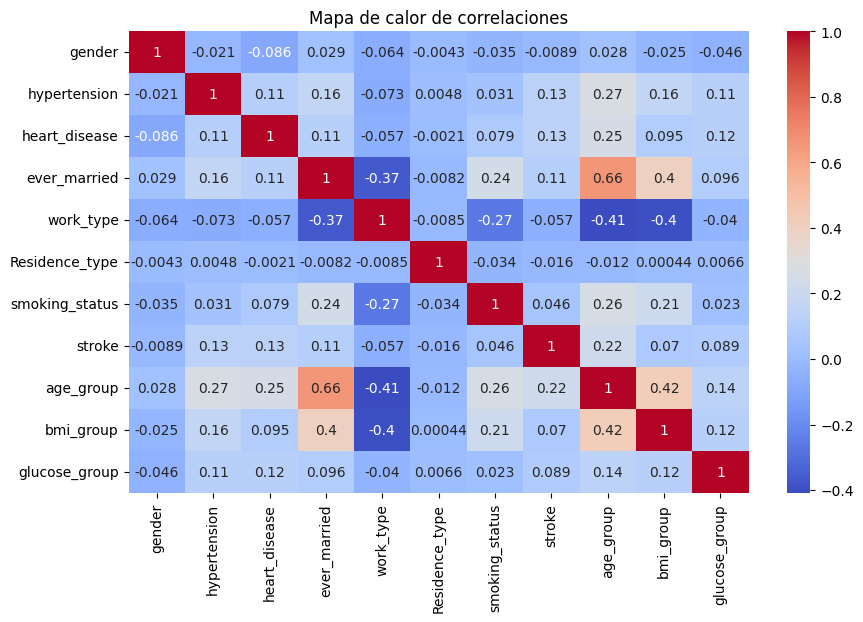

In [121]:
# Heatmap de correlación entre variables numéricas
corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

Con este gráfico de correlaciones, no detectamos ningún patron mortante, las unicas corelaciones que podemos observar es un aumento de 'ever_married' en función del aumento de 'age', esto como correlación más fuerte, pero supondría solo un 0.68. Y la siguiente correlación podria ser el aumento de 'bmi' en funcion de 'age' y 'ever_married', pero no es una correlación muy relevante.

In [122]:
# Guardamos el dataset tratado en un archivo csv
#df.to_csv('dataset_divido_rangos.csv', index=False)

***Preprocesamiento de datos***

In [123]:
df.columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'stroke', 'age_group', 'bmi_group',
       'glucose_group'],
      dtype='object')

In [124]:
#separar variables categoricas y numericas

var_num =['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'age_group', 'bmi_group',
       'glucose_group']


In [125]:
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,age_group,bmi_group,glucose_group
0,0,0,1,1,0,0,1,1,3,3,2
1,0,0,1,1,0,1,0,1,3,3,1
2,1,0,0,1,0,0,2,1,2,3,2
3,1,1,0,1,1,1,0,1,3,1,2
4,0,0,0,1,0,0,1,1,3,2,2


In [129]:
# Codificación de las variables categóricas utilizando StandarScaler

# Creamos un objeto StandardScaler
scaler = StandardScaler()

# Estandarizamos las variables float
df[var_num] = scaler.fit_transform(df[var_num])

# Mostramos un vistazo a las variables estandarizadas
print(df[var_num].head())

     gender  hypertension  heart_disease  ever_married  work_type  \
0 -1.183909     -0.326186       4.136753      0.720137  -0.749248   
1 -1.183909     -0.326186       4.136753      0.720137  -0.749248   
2  0.844660     -0.326186      -0.241735      0.720137  -0.749248   
3  0.844660      3.065738      -0.241735      0.720137   0.158561   
4 -1.183909     -0.326186      -0.241735      0.720137  -0.749248   

   Residence_type  smoking_status  age_group  bmi_group  glucose_group  
0       -0.983473        0.471674   1.255929   1.027667       1.587271  
1        1.016804       -0.891882   1.255929   1.027667       0.320252  
2       -0.983473        1.835229   0.299972   1.027667       1.587271  
3        1.016804       -0.891882   1.255929  -1.081009       1.587271  
4       -0.983473        0.471674   1.255929  -0.026671       1.587271  


In [127]:
#No se estandariza ya que LigthGB no es necesario estandarizar

***Equilibro de datos, entrenamiento del modelo***

In [138]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Separar las características (X) y la variable objetivo (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# Dividir el dataset en entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para aumentar la clase minoritaria en el conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Mostrar el número de ejemplos en cada clase después de aplicar SMOTE
print("Distribución de clases después de aplicar SMOTE:")
print(y_train_resampled.value_counts())


Distribución de clases después de aplicar SMOTE:
stroke
0    2839
1    2839
Name: count, dtype: int64


In [139]:
# Definir la función de objetivo para Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 20, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }

    model = lgb.LGBMClassifier(**params)

    # Validación cruzada
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    return np.mean(scores)

In [140]:
# Realizar la optimización de hiperparámetros con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-10-13 20:11:12,429] A new study created in memory with name: no-name-14d9f3ca-98dd-49dd-ab61-47d482ce948e
[I 2024-10-13 20:11:23,584] Trial 0 finished with value: 0.9596772041943291 and parameters: {'num_leaves': 63, 'learning_rate': 0.07253870090876019, 'n_estimators': 828, 'min_child_samples': 66, 'subsample': 0.12848069604356782, 'colsample_bytree': 0.8329589588157564}. Best is trial 0 with value: 0.9596772041943291.
[I 2024-10-13 20:11:40,122] Trial 1 finished with value: 0.9466439163616057 and parameters: {'num_leaves': 133, 'learning_rate': 1.724289007258783e-05, 'n_estimators': 594, 'min_child_samples': 18, 'subsample': 0.7878587711348652, 'colsample_bytree': 0.8155125006533358}. Best is trial 0 with value: 0.9596772041943291.
[I 2024-10-13 20:11:40,511] Trial 2 finished with value: 0.9189923683067569 and parameters: {'num_leaves': 97, 'learning_rate': 0.007531582206857395, 'n_estimators': 22, 'min_child_samples': 13, 'subsample': 0.6493675889744109, 'colsample_bytree': 

In [141]:
# Obtener los mejores parámetros
best_params = study.best_params
print("Mejores parámetros:", best_params)

Mejores parámetros: {'num_leaves': 22, 'learning_rate': 0.04050335496125731, 'n_estimators': 833, 'min_child_samples': 3, 'subsample': 0.25325104716806746, 'colsample_bytree': 0.3135280924735537}


In [142]:
# Entrenar el modelo con los mejores parámetros
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_resampled, y_train_resampled)

LGBMClassifier(colsample_bytree=0.3135280924735537,
               learning_rate=0.04050335496125731, min_child_samples=3,
               n_estimators=833, num_leaves=22, subsample=0.25325104716806746)

In [143]:
# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("Evaluación en el conjunto de validación:")
print(classification_report(y_val, y_val_pred))


Evaluación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       947
           1       0.25      0.04      0.07        49

    accuracy                           0.95       996
   macro avg       0.60      0.52      0.52       996
weighted avg       0.92      0.95      0.93       996



In [144]:

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("Evaluación en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred))

Evaluación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       947
           1       0.21      0.06      0.09        50

    accuracy                           0.94       997
   macro avg       0.58      0.52      0.53       997
weighted avg       0.92      0.94      0.93       997



<ipython-input-145-df2c46654d70>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


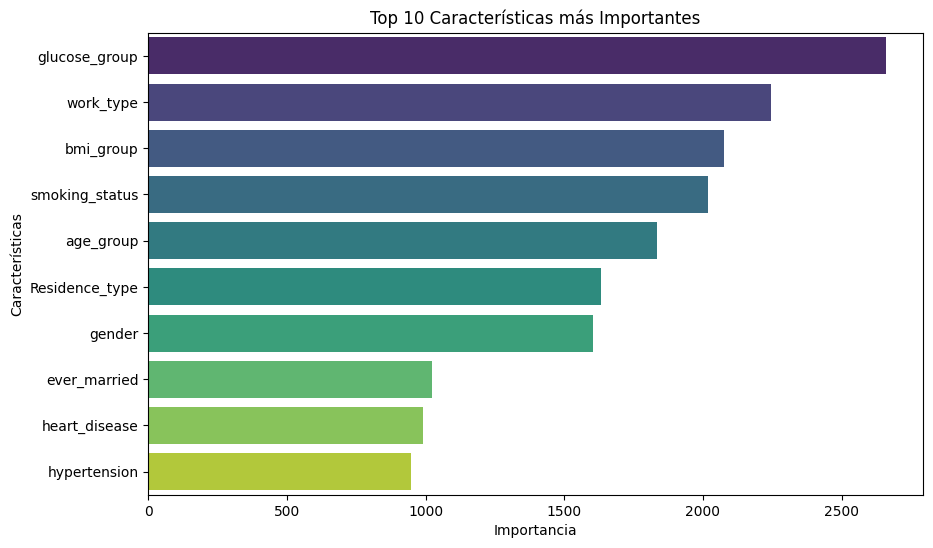

In [145]:
# Obtener la importancia de las características
importance = model.feature_importances_
features = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Características más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()